In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# for interactive plots in notebook
%matplotlib inline

import scipy.integrate as integrate
import scipy.io as sio
#from Lorenz96_RK4 import Lorenz96
from L96_Model import L96
import sys, os, time, datetime
import pickle

codename = 'v04'
np.set_printoptions(precision=4, linewidth=100)

In [42]:
# Data, Data Assimilation Hyperparameters
D = 20
Dobs = 12
dims = set(np.arange(20))
#dim_obs = [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 18, 19]
dim_obs = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 17, 18]
dim_unobs = list(dims - set(dim_obs))
M = 200

# Annealing Hyperparameters
Rm = float(1)
Rf0 = 1e-2
alpha = 1.5
betamax = 50


# Hamiltonian Monte Carlo Hyperparameters
niter = int(1e3)
Te = np.exp(1e-1*np.arange(niter))  # Temperature
epsilon = 1e-3*np.ones(niter)
L = 150
mass = [1e2, 1e-2, 1e0]
# Hamiltonian Monte Carlo Tuning Parameters
mass_X = np.zeros(shape=(D,M))
mass_X[dim_obs,:] = mass[0]
mass_X[dim_unobs,:] = mass[1]
mass_nu = mass[2]

mass_X_sqrt = np.zeros(shape=(D,M))
mass_X_sqrt[dim_obs,:] = np.sqrt(2*mass[0])
mass_X_sqrt[dim_unobs,:] = np.sqrt(2*mass[1])
mass_nu_sqrt = np.sqrt(2*mass[2])

# Post-processing
plot_Action_vs_beta = False
savedata = False

In [43]:
# Load the data set
gen_nu = "8.17"
gen_noise = "sig0.4"
gen_dt = "0.001"
gen_delta_t = "0.025"
gen_integrator = "RK4"

# Specify the data path
datapath = ("./L96_D%s_nu%s_%s_dt%s_deltat%s_%s.mat" % 
    (str(D), gen_nu, gen_noise, gen_dt, gen_delta_t, gen_integrator))

if datapath[-3:] == "mat":
    datadict = sio.loadmat(datapath)
    data = datadict["Data"]
    dt = datadict["delta_t"][0]
elif datapath[-3:] == "npy":
    data = np.load(datapath)
else:
    raise IOError ("Does not recognize data file extension\n datapath = %s" % datapath)
    sys.exit()

In [60]:
# Prepare the data

Y = data[dim_obs,:M]

#Initialize the state variables
nu_init = 8

np.random.seed(12345)
X_init = np.zeros((D,M))
X_init[:,0] = 20*np.random.random(size=(D)) - 10
X_init[dim_obs, :] = Y

for k in range(0, M-1): 
    X_init[:,k+1] = X_init[:,k] + dt *  L96(X_init[:,k]+dt/2*L96(X_init[:,k], nu_init),nu_init)
    X_init[dim_obs,k+1] = Y[:,k+1]

In [45]:
# Initilize vectorized dirac delta functions
eyeDleft1 = np.roll(np.eye(D), -1, 1)
eyeDleft2 = np.roll(np.eye(D),-2,1)
eyeDright1 = np.roll(np.eye(D),1,1)
eyeD = np.eye(D)
# Some initializations for HMC

# Define the Rf ladder
Rf = Rf0 * (alpha**(np.arange(0,betamax)))

# Initialize the solutions
X_sol = X_init
nu_sol = nu_init
# Initialize the final output cell array. (It is a dict in order to replicate the cells data type in MATLAB)
# This will contain the final X_sol for each beta, and nu_sol for eah beta
q_min = {'X_min': np.zeros(shape=(D,M,betamax)), 'nu_min': np.zeros(shape=(betamax))}

#Initialize action matrix
Action = np.zeros(shape=(betamax, niter))  #in MATLAB code, the shape is (betamax, niter+1). Not sure why the +1
Action_min = np.zeros(shape=(betamax,1))

# Percentage acceptance and percentage downhill
Acceptance = np.zeros(shape=(betamax,1))
Downhill = np.zeros(shape=(betamax, 1))

# Initialize Momentum
pX0 = np.zeros(shape=(D,M))

In [46]:
def fun_A(X, Xleft1, hX, Y, dim_obs, M, Rm, Rf):
    kern1 = Rm/(2*M) * np.sum((X[dim_obs,:] - Y)**2)
    
    kern2 = Xleft1 - hX
    kern2 = Rf/(2*M) * np.sum(kern2[:,:M-1]**2) # Is this right? I feel like it's leaving out one column
    
    
    return kern1 + kern2

In [47]:
def fun_getPieces(X, nu, dt):
    Xup1 = np.roll(X, -1, 0)
    Xdown1 = np.roll(X, 1, 0)
    Xdown2 = np.roll(X, 2, 0)
    Xleft1 = np.roll(X, -1, 1)
    
    Z = X + dt/2* (np.multiply(Xup1 - Xdown2, Xdown1) - X + nu)
    Zup1 = np.roll(Z, -1, 0)
    Zdown1 = np.roll(Z, 1, 0)
    Zdown2 = np.roll(Z, 2, 0)
    
    hX = X + dt * (np.multiply(Zup1 - Zdown2, Zdown1) - Z + nu)
    
    return Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX

In [48]:
def fun_dAnu(Xleft1, Zup1, Zdown2, hX, M, dt, Rf):
    kern = np.multiply(Xleft1 - hX, dt + dt**2/2*(Zup1 - Zdown2 - 1))
    dAnu = -Rf/M * np.sum(kern[:,:-1])
    return dAnu

In [49]:
def fun_dAX(X, Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX, Y, eyeD, eyeDleft1, eyeDleft2, eyeDright1, D, dim_obs, M, dt, Rm, Rf):
    
    GX = (np.multiply(eyeDleft1[:,:,None], np.transpose(Xup1[:,:,None] - Xdown2[:,:,None], (0, 2, 1))) 
               + np.multiply(eyeDright1[:,:,None] - eyeDleft2[:,:,None], np.transpose(Xdown1[:,:,None], (0, 2, 1))) - eyeD[:,:,None])
    
    GZ = (np.multiply(eyeDleft1[:,:,None], np.transpose(Zup1[:,:,None] - Zdown2[:,:,None], (0, 2, 1))) 
          + np.multiply(eyeDright1[:,:,None] - eyeDleft2[:,:,None], np.transpose(Zdown1[:,:,None], (0, 2, 1))) - eyeD[:,:,None])
      
    GZGX = np.zeros(shape=(D,D,M))
    for k in xrange(M):
        GZGX[:,:,k] = np.matmul(GZ[:,:,k], GX[:,:,k])   

    
    T = eyeD[:,:,None] + dt*GZ + dt**2 / 2*GZGX
      
    kern3 = -Rf/M * np.transpose(np.sum(np.transpose(Xleft1[:,:,None] - hX[:,:,None], (0, 2, 1)) * T,axis=0)[None,:,:], (1, 2, 0))[:,:,0]
    test = (np.transpose(np.sum(np.transpose(Xleft1[:,:,None] - hX[:,:,None], (0, 2, 1)) * T,axis=0)[None,:,:], (1, 2, 0))[:,:,0])
    
    kern3[:,M-1] = 0 # What is this for?
    
    kern1 = np.zeros(shape=(D,M))
    kern1[dim_obs,:] = float(Rm)/M * (X[dim_obs,:] - Y)
    
    kern2 = Rf/M * (X - np.roll(hX, 1, 1))
    kern2[:,0] = 0
    
        
    dAX = kern1 + kern2 + kern3
    return dAX

In [50]:
# Hamiltonian Monte Carlo Algorithm

for beta in range(betamax):
    # Initialize states (i.e. take the results from the previous step)
    X0 = X_sol
    X0[dim_obs,:] = Y  # Is this really necessary?
    nu0 = nu_sol
    
    # Evaluate the starting action under current beta
    Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX = fun_getPieces(X0, nu0, dt)
    Action[beta, 0] = fun_A(X0, Xleft1, hX, Y, dim_obs, M, Rm, Rf[beta])
    Action_min[beta] = Action[beta, 0]
    
    print("Start annealing for beta = %d ..." % beta)
    start_time = time.time()
    
    for n in range(niter-1):
        eps = epsilon[n]   
        # Take current q as starting point
        X = X0
        nu = nu0
        
        # Generate initial momenta from a multivariate normal distribution
        pX0[dim_obs,:] = np.random.normal(0, np.sqrt(mass[0]), size=(Dobs,M))
        pX0[dim_unobs,:] = np.random.normal(0, np.sqrt(mass[1]), size=(D-Dobs, M))
        pnu0 = np.random.normal(0, np.sqrt(mass[2]))
        
        arg_p = Action[beta, n] + np.sum(np.divide(pX0, mass_X_sqrt)**2) + (pnu0 / mass_nu_sqrt)**2
        
        # Get necessary pieces
        Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX = fun_getPieces(X, nu, dt)
        
        # Half step for the X momenta
        pX = pX0 - eps/2*fun_dAX(X, Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX, Y, 
                                 eyeD, eyeDleft1, eyeDleft2, eyeDright1, D, dim_obs, M, dt, Rm, Rf[beta])
        # Half step for the nu momentum
        pnu = pnu0 - eps/2*fun_dAnu(Xleft1, Zup1, Zdown2, hX, M, dt, Rf[beta])
        
        for i in xrange(L):
            # Full step for the state variables
            X = X + eps*np.divide(pX, mass_X)
            nu = nu + eps*pnu/mass_nu
            
            # Get necessary pieces
            Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX = fun_getPieces(X, nu, dt)
            if i != L-1:
                # Full step for X momenta at end of trajectory
                pX = pX - eps*fun_dAX(X, Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX, Y, 
                                 eyeD, eyeDleft1, eyeDleft2, eyeDright1, D, dim_obs, M, dt, Rm, Rf[beta])
                # Full step for the nu momentum exept at end of trajectory
                pnu = pnu - eps*fun_dAnu(Xleft1, Zup1, Zdown2, hX, M, dt, Rf[beta])
            

       # Half step for the X momenta
        pX = pX - eps/2*fun_dAX(X, Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX, Y, 
                                 eyeD, eyeDleft1, eyeDleft2, eyeDright1, D, dim_obs, M, dt, Rm, Rf[beta])
        # Half step for the nu momentum
        pnu = pnu - eps/2*fun_dAnu(Xleft1, Zup1, Zdown2, hX, M, dt, Rf[beta])
        
        # Calculate Action when simulation is done
        Action_candidate = fun_A(X, Xleft1, hX, Y, dim_obs, M, Rm, Rf[beta])

        # Metropolis-Hastings acceptance/rejection rule
        accept_prob = (np.exp((Action[beta, n] + np.sum(np.divide(pX0, mass_X_sqrt)**2) # is the index for n right here?
                                        + (pnu0 / mass_nu_sqrt)**2 
                                        - Action_candidate - np.sum(np.divide(pX, mass_X_sqrt)**2)
                                       - (pnu / mass_nu_sqrt)**2 ) / Te[n]))

        if np.random.uniform() < accept_prob:
            X0 = X
            nu0 = nu
            Action[beta, n+1] = Action_candidate
            # Count acceptance rate
            Acceptance[beta] += 1
        else:
            Action[beta, n+1] = Action[beta, n]
            
        # Check if the current proposal yields the lowest action so far
        if Action[beta, n] < Action_min[beta]:
            Action_min[beta] = Action[beta, n]
            X_sol = X0
            nu_sol = nu0
            Downhill[beta] += 1
        
        
    print("Done! Time elapsed: %.2fsec" % (time.time() - start_time))
    
    # Record argmin(A[:,beta]) for the current beta
    q_min['X_min'][:,:,beta] = X_sol
    q_min['nu_min'][beta] = nu_sol
    
    # Finalize these acceptances
    Acceptance[beta] /= niter
    Downhill[beta] /= niter
    
print("\n")

Start annealing for beta = 0 ...
Done! Time elapsed: 833.31sec
Start annealing for beta = 1 ...
Done! Time elapsed: 845.23sec
Start annealing for beta = 2 ...
Done! Time elapsed: 867.27sec
Start annealing for beta = 3 ...
Done! Time elapsed: 839.71sec
Start annealing for beta = 4 ...
Done! Time elapsed: 895.05sec
Start annealing for beta = 5 ...
Done! Time elapsed: 874.04sec
Start annealing for beta = 6 ...
Done! Time elapsed: 872.51sec
Start annealing for beta = 7 ...
Done! Time elapsed: 849.76sec
Start annealing for beta = 8 ...
Done! Time elapsed: 877.90sec
Start annealing for beta = 9 ...
Done! Time elapsed: 930.59sec
Start annealing for beta = 10 ...
Done! Time elapsed: 882.89sec
Start annealing for beta = 11 ...
Done! Time elapsed: 853.22sec
Start annealing for beta = 12 ...
Done! Time elapsed: 810.78sec
Start annealing for beta = 13 ...
Done! Time elapsed: 800.91sec
Start annealing for beta = 14 ...
Done! Time elapsed: 849.93sec
Start annealing for beta = 15 ...
Done! Time elaps

c:\python27\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp


Done! Time elapsed: 665.01sec
Start annealing for beta = 45 ...
Done! Time elapsed: 662.25sec
Start annealing for beta = 46 ...
Done! Time elapsed: 662.54sec
Start annealing for beta = 47 ...


c:\python27\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':
c:\python27\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
c:\python27\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
c:\python27\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\python27\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
c:\python27\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
c:\python27\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
c:\python27\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
c:

Done! Time elapsed: 648.37sec
Start annealing for beta = 48 ...
Done! Time elapsed: 643.14sec
Start annealing for beta = 49 ...
Done! Time elapsed: 643.18sec




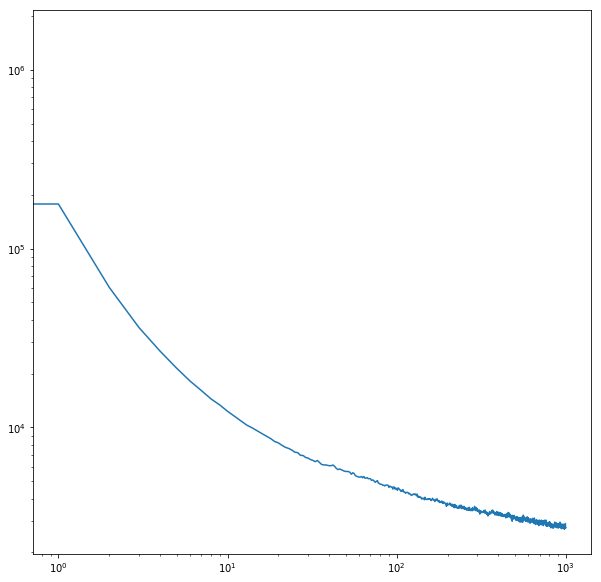

In [53]:
plot_Action_vs_beta = 1
if plot_Action_vs_beta == 1:
    plt.figure(figsize=(10,10))
#     plt.plot(Action[49,:])
    plt.plot(np.arange(niter), Action[-5,:])
#     plt.plot(Action_min)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

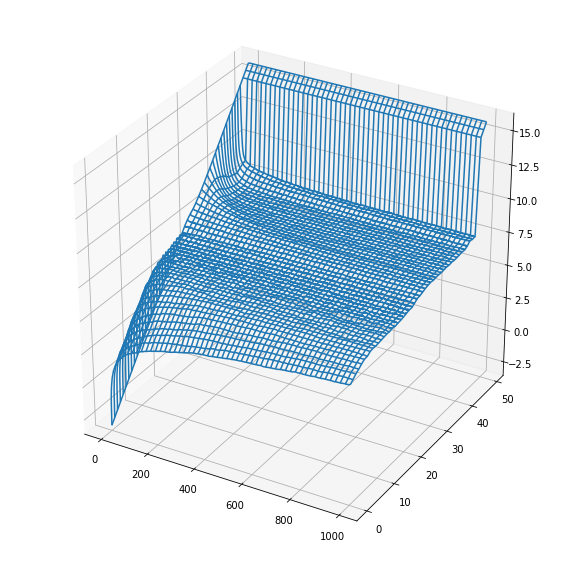

In [69]:
fig = plt.figure(figsize=(10,10))
X, Y = np.meshgrid(np.arange(niter), np.arange(betamax))

def f(X,Y):
    return np.sin(X**2 + Y**2)
Z = Action

ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, np.log(Z));

plt.show()

In [62]:
# Infer new variables and save useful variables
Action_init = np.zeros(betamax)
for beta in xrange(betamax):
    Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX = fun_getPieces(X_init, nu_init, dt)
    Action_init[beta] = fun_A(X_init, Xleft1, hX, Y, dim_obs, M, Rm, Rf[beta])
    
    
ME = np.zeros(betamax)
FE = np.zeros(betamax)
for beta in xrange(betamax):
    # Evaluate Measurement Error
    ME[beta] = 1/(2*M) * np.sum((q_min['X_min'][dim_obs,:,beta] - Y)**2)
    # Evaluate Model Error
    Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX = fun_getPieces(q_min['X_min'][:,:,beta], q_min['nu_min'][beta], dt)
    kern2 = Xleft1 - hX
    FE[beta] = 1/(2*M) * np.sum((kern2[:,:M-1]))

    
mass_string = []
for m in mass:
    mass_string.append(m)

In [63]:
# Save Data
savedata = 1
if savedata == 1:
    # Note, some pieces will have incorrect indexing (e.g. dim_obs). 
    # Maybe save it in a different way (e.g. in an .npy file), otherwise, save it twice?
    date = datetime.datetime.today()
    filename = "v04_%d-%s-%d_%d" % (date.day, date.month, date.year, np.random.randint(1000,9999))
    keys = ['Acceptance', 'Action', 'Action_init', 'Action_min', 'alpha',
           'betamax', 'codename', 'D', 'dim_obs', 'Dobs', 'Downhill', 'dt',
           'epsilon', 'FE', 'gen_nu', 'gen_noise', 'gen_dt', 'gen_delta_t',
           'gen_integrator', 'L', 'M', 'mass', 'ME', 'niter', 'q_min', 'Rf', 'Rf0',
           'Rm', 'Te']
    values = [Acceptance, Action, Action_init, Action_min, alpha,
             betamax, codename, D, dim_obs, Dobs, Downhill, dt,
             epsilon, FE, gen_nu, gen_noise, gen_dt, gen_delta_t,
             gen_integrator, L, M, mass, ME, niter, q_min, Rf, Rf0,
             Rm, Te]
    mdict = dict(zip(keys, values))
    sio.savemat(filename, mdict)

